In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import pickle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns
from sklearn.covariance import MinCovDet
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import OneClassSVM
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN

In [8]:
from sklearn.linear_model import LinearRegression
class DetectorEnsemble:
    def __init__(self):
        self.detectors = []
        self.detectors.append(('knn', NearestNeighbors(algorithm='ball_tree')))
        self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed")))
        #self.detectors.append(('robustcov', MinCovDet()))
        self.detectors.append(('iforest', IsolationForest()))
        self.detectors.append(('ocsvm', OneClassSVM()))
        self.detectors.append(('dbscan',  DBSCAN()))
    
    def fit_detector(self, X, y):
        self.clf = LinearRegression(fit_intercept=True, normalize=False, copy_X=True).fit(X, y)

    def fit(self, mat):
        dist = pairwise_distances(X = mat, metric='euclidean')
        self.scores = []
        for (name, detector) in self.detectors:
            if name[:3] == 'lof':
                detector.fit_predict(dist)
                self.scores.append(-detector.negative_outlier_factor_)
            elif name == 'robustcov':
                detector.fit(mat)
                self.scores.append(detector.mahalanobis(mat))
            elif name == 'knn':
                detector.fit(mat)
                self.scores.append(-detector.kneighbors(mat)[0][:, -1])
            elif name == 'dbscan':
                detector.fit(mat)
                score = np.array([1 if x == -1 else 0 for x in detector.labels_])
                self.scores.append(score)
            else:
                detector.fit_predict(mat)
                self.scores.append(-detector.score_samples(mat))
            print(name, min(self.scores[-1]), max(self.scores[-1]), self.scores[-1].shape)
        tmp = []
        for score in self.scores:
            min_s = np.min(score)
            max_s = np.max(score)
            range_s = max(1, max_s - min_s)
            score = (score - min_s) / range_s
            tmp.append(score)
        self.n = mat.shape[0]
        self.scores = np.array(tmp)
        self.ground_truth = {}
        self.adjust_sample_weight = self.n // 100
        self.weights = np.ones(len(self.detectors))
        weights = self.weights / np.sum(self.weights)

        self.scores = self.scores.transpose()
        y = (self.scores * weights).sum(axis = 1)
        print('before fit', self.scores.shape, y.shape)
        self.fit_detector(self.scores, y)
        print('after fit')
    
    def weighted_score(self):
        y = self.clf.predict(self.scores)
        for i in self.ground_truth:
            y[i] = self.ground_truth[i]
        return y

    def adjust_weight(self, idx, score):
        self.ground_truth[idx] = score
        sample_weight = np.ones(self.n)
        for i in self.ground_truth:
            sample_weight[i] = self.adjust_sample_weight
        y = self.weighted_score()
        self.fit_detector(self.scores, y)

In [9]:
data = pickle.loads(open('german_rf.pkl', 'rb').read())
paths, X, y = data['paths'], data['X'], data['y']

In [4]:
def rule_sample(path, X):
    ans = np.ones(X.shape[0])
    m = path.get('range')
    for key in m:
        ans = ans * (X[:, int(key)] >= m[key][0]) * (X[:, int(key)] < m[key][1])
    return ans
    
mat = np.array([rule_sample(p, X) for p in paths]).astype('float')

In [10]:
ensemble = DetectorEnsemble()
ensemble.fit(mat)

knn -10.535653752852738 -1.0 (8837,)
lof 0.9679443835446182 1.8939706196064616 (8837,)
iforest 0.2997034528404443 0.5154931433537278 (8837,)
ocsvm -916.1161887424739 -3.0160576770049374 (8837,)
dbscan 1 1 (8837,)
before fit (8837, 5) (8837,)
after fit


/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [11]:
f = open('diff_ensemble.txt', 'w')
for i in ensemble.weighted_score().argsort()[:-50][::-1]:
    f.write(str(i) + '\n')
f.close()

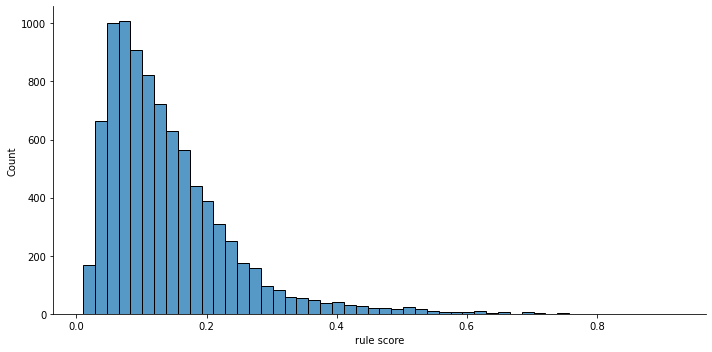

In [22]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({ 'rule score': score })
sns.displot(df, x='rule score', bins=50, aspect=2)

<AxesSubplot:xlabel='x', ylabel='y'>

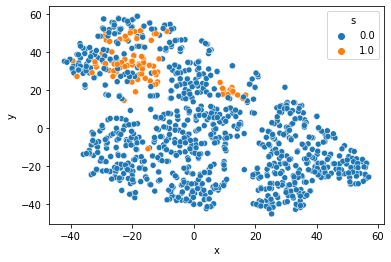

In [54]:
df = pd.DataFrame({ 'x': X[:, 0], 'y': X[:, 1], 's': mat[rank[-10]] })
sns.scatterplot(data=df, x='x', y='y', hue='s')

In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE

X = TSNE(n_components=2).fit_transform(mat.transpose())


/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [17]:
df.corr()

,lof1,lof2,lof3,iforest1,iforest2,ocsvm
lof1,1.000000,0.967197,0.936530,0.539745,0.573110,0.590451
lof2,0.967197,1.000000,0.989694,0.630189,0.663776,0.682371
lof3,0.936530,0.989694,1.000000,0.695139,0.728466,0.748755
iforest1,0.539745,0.630189,0.695139,1.000000,0.967835,0.930129
iforest2,0.573110,0.663776,0.728466,0.967835,1.000000,0.963111
ocsvm,0.590451,0.682371,0.748755,0.930129,0.963111,1.000000


In [16]:
df = pd.DataFrame({
    'lof1': scores[0],
    'lof2': scores[1],
    'lof3': scores[2],
    'iforest1': scores[3],
    'iforest2': scores[4],
    'ocsvm': scores[5],
})

In [56]:
np.ones((3,5)) * np.ones(5)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])